# Lending club model drift simulation

In [ ]:
from __future__ import annotations

from pathlib import Path
from typing import Callable
import subprocess
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


def _ensure_numpy_lt2() -> None:
    major_minor = tuple(int(part) for part in np.__version__.split(".")[:2])
    if major_minor < (2, 0):
        return

    print(
        "Detected NumPy",
        np.__version__,
        "but this notebook requires numpy<2 for compiled extensions. Downgrading...",
    )
    subprocess.run([sys.executable, "-m", "pip", "install", "numpy<2"], check=True)
    raise SystemExit(
        "NumPy was downgraded. Restart the kernel (Kernel > Restart Kernel) and rerun the notebook."
    )


_ensure_numpy_lt2()

pd.options.display.float_format = "{:.3f}".format
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = Path("/content/drive/MyDrive/MLOpsFinal/Final Datasets & Files/val.csv")
OUTPUT_PATH = DATA_PATH.parent / "val_drifted.csv"

rng = np.random.default_rng(2024)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv(DATA_PATH, low_memory=False)
df_drifted = df.copy(deep=True)

print(f"Rows: {len(df):,}")
print(f"Columns: {len(df.columns)}")
df.head()

Rows: 269,062
Columns: 86


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,default_flag
0,12000.000,12000.000,11975.000,60 months,17.570,301.930,D,D4,6 years,MORTGAGE,...,0.000,0.000,187221.000,71504.000,8100.000,72780.000,N,Cash,Y,1
1,4000.000,4000.000,4000.000,36 months,15.220,139.100,C,C3,2 years,RENT,...,0.000,1.000,26900.000,4955.000,23800.000,0.000,N,Cash,N,0
2,12000.000,12000.000,12000.000,36 months,9.930,386.820,B,B2,NaN,OWN,...,1.000,0.000,662497.000,32506.000,21500.000,24497.000,N,Cash,N,0
3,28100.000,28100.000,27800.000,60 months,19.030,729.400,E,E2,10+ years,MORTGAGE,...,0.000,0.000,NaN,NaN,NaN,NaN,N,Cash,N,0
4,15000.000,15000.000,15000.000,36 months,9.490,480.430,B,B2,< 1 year,MORTGAGE,...,0.000,0.000,244350.000,36354.000,25400.000,24693.000,N,Cash,N,0


# **Drift method**

We now run each numeric feature through its own custom generator and make sure to keep the original meanm and we add outliers. This makes the drift reflect a truly different distribution shape.

In [ ]:
def to_numeric(series: pd.Series) -> pd.Series:
    return pd.to_numeric(series.astype(str).str.rstrip('%'), errors="coerce")

summary_records: list[dict[str, float | int | str]] = []
rows_changed = pd.Series(False, index=df.index)


def _numeric_summary(series: pd.Series) -> tuple[float, float, float]:
    numeric = pd.to_numeric(series, errors="coerce")
    if numeric.notna().any():
        return numeric.mean(), numeric.min(), numeric.max()
    return np.nan, np.nan, np.nan


def track_changes(feature: str, before: pd.Series, after: pd.Series) -> None:
    mask = ~((before == after) | (before.isna() & after.isna()))
    rows_changed.loc[mask.index] |= mask.fillna(False)

    before_mean, before_min, before_max = _numeric_summary(before)
    after_mean, after_min, after_max = _numeric_summary(after)

    summary_records.append(
        {
            "feature": feature,
            "before_mean": before_mean,
            "after_mean": after_mean,
            "before_min": before_min,
            "after_min": after_min,
            "before_max": before_max,
            "after_max": after_max,
            "rows_modified": int(mask.sum()),
        }
    )


def rebalance_mean(values: np.ndarray, target_mean: float) -> np.ndarray:
    current_mean = np.nanmean(values)
    if np.isnan(current_mean):
        return values
    return values - current_mean + target_mean


def clip_array(values: np.ndarray, clip: tuple[float | None, float | None] | None) -> np.ndarray:
    if clip is None:
        return values
    low, high = clip
    if low is not None:
        values = np.maximum(values, low)
    if high is not None:
        values = np.minimum(values, high)
    return values


def inject_outliers(
    values: np.ndarray,
    *,
    frac: float,
    low: float | None = None,
    high: float | None = None,
    clip: tuple[float | None, float | None] | None = None,
) -> np.ndarray:
    values = values.copy()
    size = values.size
    if size == 0 or frac <= 0:
        return values
    total = max(1, int(size * frac))
    indices = np.arange(size)
    rng.shuffle(indices)

    low_count = 0
    high_count = 0
    if low is not None and high is not None:
        low_count = max(1, total // 2)
        high_count = max(1, total - low_count)
    elif low is not None:
        low_count = total
    elif high is not None:
        high_count = total

    low_count = min(low_count, size)
    high_count = min(high_count, size - low_count)

    cursor = 0
    if low is not None and low_count > 0:
        low_idx = indices[cursor : cursor + low_count]
        values[low_idx] = low
        cursor += low_count
    if high is not None and high_count > 0:
        high_idx = indices[cursor : cursor + high_count]
        values[high_idx] = high

    return clip_array(values, clip)


def apply_distributional_shift(
    col: str,
    generator: Callable[[int, np.ndarray], np.ndarray],
    *,
    clip: tuple[float | None, float | None] | None = None,
    as_int: bool = False,
    percent_format: bool | None = None,
    outlier_cfg: dict[str, float] | None = None,
    postprocess: Callable[[pd.Series], pd.Series] | None = None,
) -> None:
    if col not in df_drifted.columns:
        return

    before = to_numeric(df[col])
    mask = before.notna()
    if mask.sum() == 0:
        return

    reference = before.loc[mask].astype(float).to_numpy()
    generated = np.asarray(generator(mask.sum(), reference), dtype=float)
    if generated.size != mask.sum():
        raise ValueError(f"Generator for {col} returned the wrong shape.")

    target_mean = np.nanmean(reference)
    generated = rebalance_mean(generated, target_mean)
    generated = clip_array(generated, clip)

    if outlier_cfg:
        generated = inject_outliers(
            generated,
            frac=outlier_cfg.get("frac", 0.01),
            low=outlier_cfg.get("low"),
            high=outlier_cfg.get("high"),
            clip=clip,
        )
        generated = rebalance_mean(generated, target_mean)
        generated = clip_array(generated, clip)

    after_numeric = before.copy()
    after_numeric.loc[mask] = generated
    if postprocess is not None:
        after_numeric = postprocess(after_numeric)

    pct_format = percent_format
    if pct_format is None:
        pct_format = df[col].astype(str).str.contains('%').any()

    if as_int:
        df_drifted[col] = after_numeric.round().astype(pd.Int64Dtype())
    elif pct_format:
        df_drifted[col] = after_numeric.round(2).map(lambda x: f"{x:.2f}%" if pd.notna(x) else np.nan)
    else:
        df_drifted[col] = after_numeric.round(2)

    track_changes(col, before, after_numeric)


# each feature has its own generator function that changes their distribution.
def fico_low_generator(size: int, reference: np.ndarray) -> np.ndarray:
    q1 = np.nanpercentile(reference, 25)
    q3 = np.nanpercentile(reference, 75)
    split = max(1, size // 2)
    part_a = rng.normal(loc=q1 - 60, scale=18, size=split)
    part_b = rng.normal(loc=q3 + 25, scale=22, size=size - split)
    combined = np.concatenate([part_a, part_b])
    rng.shuffle(combined)
    return combined


def fico_high_generator(size: int, reference: np.ndarray) -> np.ndarray:
    q2 = np.nanpercentile(reference, 50)
    q9 = np.nanpercentile(reference, 90)
    split = max(1, int(size * 0.35))
    part_a = rng.normal(loc=q2 - 40, scale=25, size=split)
    part_b = rng.normal(loc=q9 + 35, scale=28, size=size - split)
    combined = np.concatenate([part_a, part_b])
    rng.shuffle(combined)
    return combined


def revol_util_generator(size: int, reference: np.ndarray) -> np.ndarray:
    scale = np.nanmean(reference) / 2.0 + 1e-3
    gamma_draw = rng.gamma(shape=2.4, scale=scale, size=size)
    spike = rng.normal(loc=20, scale=8, size=size)
    return gamma_draw + np.abs(spike)


def funded_amount_generator(size: int, reference: np.ndarray) -> np.ndarray:
    median = max(np.nanmedian(reference), 1)
    samples = rng.lognormal(mean=np.log(median), sigma=0.65, size=size)
    tail = rng.normal(loc=median * 0.15, scale=median * 0.1, size=size)
    return samples + np.abs(tail)


def open_acc_generator(size: int, reference: np.ndarray) -> np.ndarray:
    base = rng.negative_binomial(n=5, p=0.35, size=size).astype(float)
    jitter = rng.normal(loc=2.5, scale=2.0, size=size)
    return np.abs(base + jitter)


def enforce_fico_high_bounds(series: pd.Series) -> pd.Series:
    if "last_fico_range_low" not in df_drifted.columns:
        return series
    low_series = to_numeric(df_drifted["last_fico_range_low"])
    adjusted = series.copy()
    mask = series.notna() & low_series.notna()
    adjusted.loc[mask] = np.where(
        series.loc[mask] < low_series.loc[mask],
        low_series.loc[mask],
        series.loc[mask],
    )
    return adjusted


distribution_plan = [
    {
        "column": "last_fico_range_low",
        "generator": fico_low_generator,
        "clip": (200, 950),
        "as_int": True,
        "outliers": {"frac": 0.015, "low": 200, "high": 920},
    },
    {
        "column": "last_fico_range_high",
        "generator": fico_high_generator,
        "clip": (300, 990),
        "as_int": True,
        "outliers": {"frac": 0.015, "low": 320, "high": 980},
        "postprocess": enforce_fico_high_bounds,
    },
    {
        "column": "revol_util",
        "generator": revol_util_generator,
        "clip": (0, 600),
        "outliers": {"frac": 0.02, "low": 0, "high": 520},
    },
    {
        "column": "funded_amnt",
        "generator": funded_amount_generator,
        "clip": (0, 120_000),
        "outliers": {"frac": 0.01, "low": 1_000, "high": 250_000},
    },
    {
        "column": "open_acc",
        "generator": open_acc_generator,
        "clip": (0, 140),
        "as_int": True,
        "outliers": {"frac": 0.02, "low": 0, "high": 120},
    },
]

for spec in distribution_plan:
    apply_distributional_shift(
        spec["column"],
        spec["generator"],
        clip=spec.get("clip"),
        as_int=spec.get("as_int", False),
        percent_format=spec.get("percent_format"),
        outlier_cfg=spec.get("outliers"),
        postprocess=spec.get("postprocess"),
    )

In [ ]:
# checking for the changed features.
key_cols = [
    "last_fico_range_low",
    "last_fico_range_high",
    "revol_util",
    "funded_amnt",
    "open_acc",
]

for col in key_cols:
    if col not in df_drifted.columns:
        continue
    numeric = to_numeric(df_drifted[col]).dropna()
    if not np.isfinite(numeric).all():
        raise ValueError(f"Detected non-finite values in {col} after remapping.")

In [ ]:
summary_df = pd.DataFrame(summary_records)
summary_df

,feature,before_mean,after_mean,before_min,after_min,before_max,after_max,rows_modified
0,last_fico_range_low,660.343,660.343,0.000,201.490,845.000,921.490,269062
1,last_fico_range_high,677.414,723.039,0.000,320.392,850.000,980.392,268608
2,revol_util,51.826,52.120,0.000,0.000,172.000,515.566,268783
3,funded_amnt,14421.765,14422.134,500.000,0.000,40000.000,119544.840,269062
4,open_acc,11.604,11.617,0.000,0.000,90.000,119.032,269062


In [ ]:
changed_rows = int(rows_changed.sum())
print(f"Total rows changed: {changed_rows:,} of {len(df):,}")

df_drifted.to_csv(OUTPUT_PATH, index=False)
print(f"Saved drifted dataset to {OUTPUT_PATH}")

df_drifted.head()

Total rows changed: 269,062 of 269,062
Saved drifted dataset to /content/drive/MyDrive/MLOpsFinal/Final Datasets & Files/val_drifted.csv


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,default_flag
0,12000.000,8646.070,11975.000,60 months,17.570,301.930,D,D4,6 years,MORTGAGE,...,0.000,0.000,187221.000,71504.000,8100.000,72780.000,N,Cash,Y,1
1,4000.000,18688.860,4000.000,36 months,15.220,139.100,C,C3,2 years,RENT,...,0.000,1.000,26900.000,4955.000,23800.000,0.000,N,Cash,N,0
2,12000.000,19381.220,12000.000,36 months,9.930,386.820,B,B2,NaN,OWN,...,1.000,0.000,662497.000,32506.000,21500.000,24497.000,N,Cash,N,0
3,28100.000,13522.100,27800.000,60 months,19.030,729.400,E,E2,10+ years,MORTGAGE,...,0.000,0.000,NaN,NaN,NaN,NaN,N,Cash,N,0
4,15000.000,24463.100,15000.000,36 months,9.490,480.430,B,B2,< 1 year,MORTGAGE,...,0.000,0.000,244350.000,36354.000,25400.000,24693.000,N,Cash,N,0


# **Before/After Feature EDA**

The plots below compare the pre-drift vs. post-drift distributions for the key features we changed.


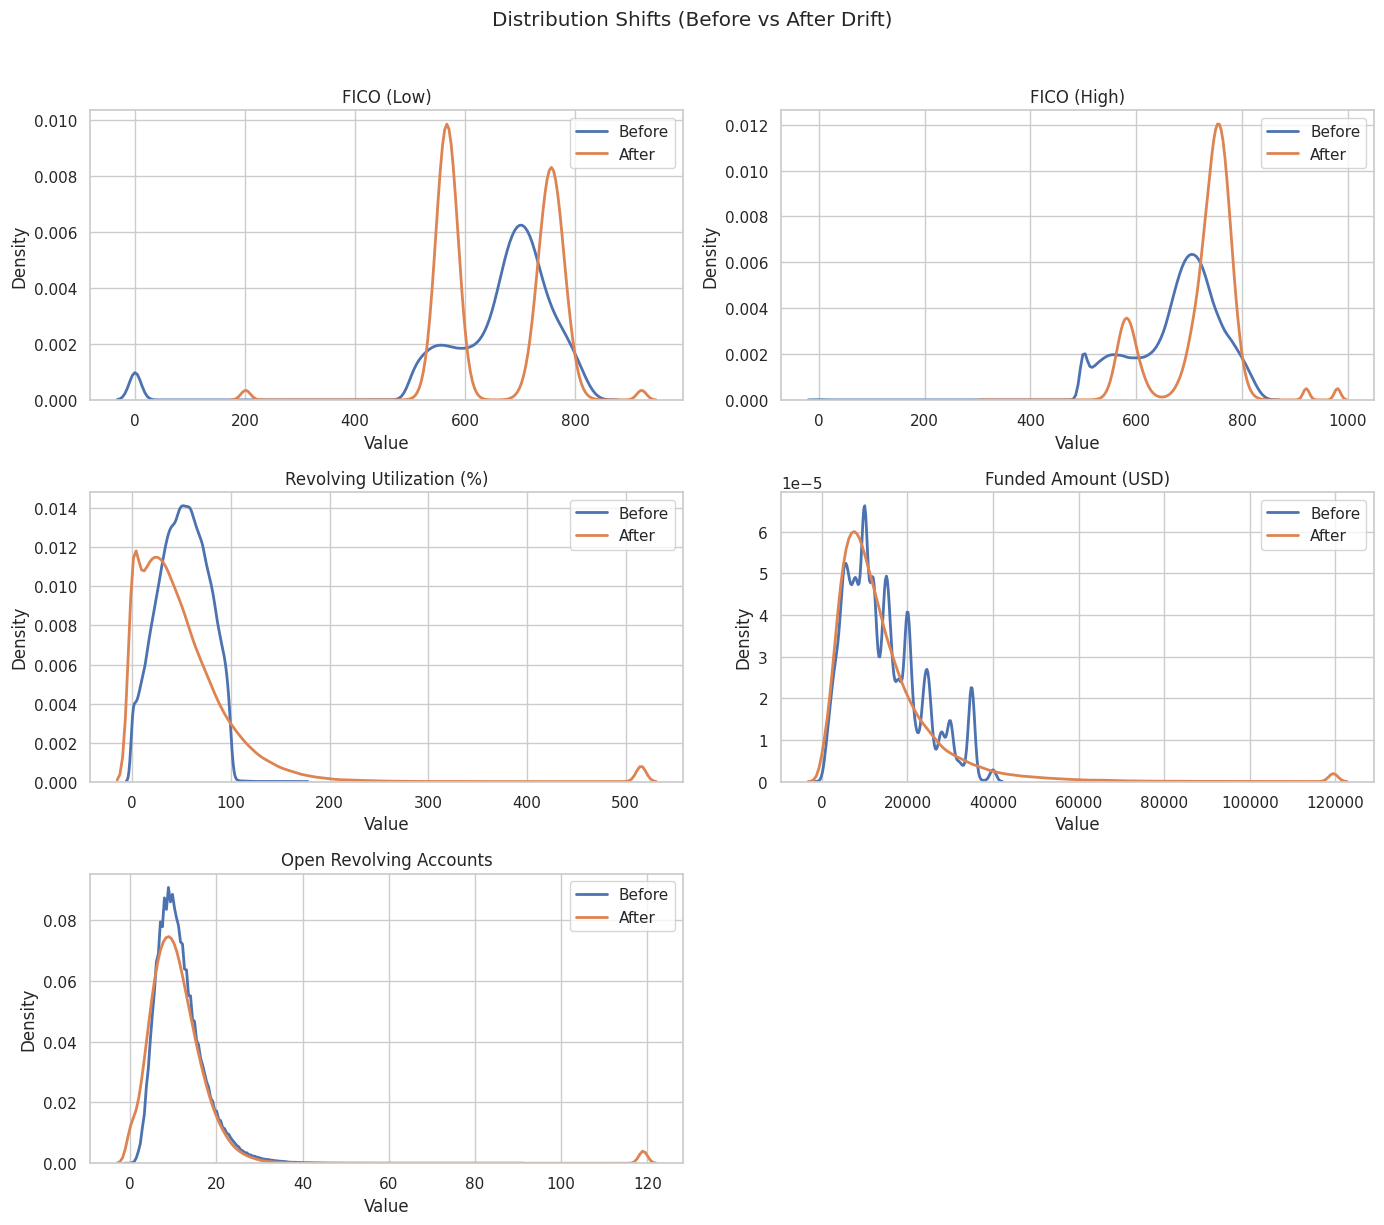

In [ ]:
import math

numeric_features = [
    ("last_fico_range_low", "FICO (Low)"),
    ("last_fico_range_high", "FICO (High)"),
    ("revol_util", "Revolving Utilization (%)"),
    ("funded_amnt", "Funded Amount (USD)"),
    ("open_acc", "Open Revolving Accounts"),
]

rows = math.ceil(len(numeric_features) / 2)
fig, axes = plt.subplots(rows, 2, figsize=(14, 4 * rows))
axes = axes.flatten()

for idx, (col, label) in enumerate(numeric_features):
    ax = axes[idx]
    if col not in df.columns:
        ax.axis("off")
        ax.set_title(f"{label} (missing)")
        continue

    before = to_numeric(df[col]).dropna()
    after = to_numeric(df_drifted[col]).dropna()

    if before.empty and after.empty:
        ax.axis("off")
        ax.set_title(f"{label} (no data)")
        continue

    sns.kdeplot(before, ax=ax, label="Before", linewidth=2)
    sns.kdeplot(after, ax=ax, label="After", linewidth=2)
    ax.set_title(label)
    ax.set_xlabel("Value")
    ax.legend()

for extra_ax in axes[len(numeric_features):]:
    extra_ax.axis("off")

plt.suptitle("Distribution shifts (before vs after)", y=1.02)
plt.tight_layout()
plt.show()
